In [160]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# -------------------------------------------------------------------- Hyperparameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001
# -------------------------------------------------------------------- //

# --------------------------------------------------------------------  Load the MNIST train and test sets
# Load the MNIST train set
train_dataset = datasets.MNIST(root='./data', train=True,
                               download=True, transform=transforms.ToTensor())

# Load the MNIST test set
test_dataset = datasets.MNIST(root='./data', train=False,
                              download=True, transform=transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)
# -------------------------------------------------------------------- //

`torch.utils.data.DataLoader` is a PyTorch utility class that helps in loading the data in batches for training a neural network. It takes the dataset (`train_dataset` in this case) and several optional arguments to configure the data loading process.

Here's an explanation of the arguments used in `torch.utils.data.DataLoader`:

* `train_dataset`: This is the training dataset object that we want to load in batches. It contains the input images and labels.

* `batch_size`: It specifies the number of samples in each batch. During training, the model will process `batch_size` number of images together and update the model's parameters based on the computed gradients. A smaller batch size can lead to more frequent parameter updates but may require more memory, while a larger batch size can improve computational efficiency but may result in slower convergence.

* `shuffle=True`: This argument controls whether to shuffle the training data before each epoch. Setting it to `True` randomizes the order of the samples in each epoch, which helps in reducing the impact of any specific order or pattern in the data. Shuffling the data is important to prevent the model from learning the order of the samples instead of the underlying patterns.


In [161]:
# -------------------------------------------------------------------- Implement a basic two-layer fully connected neural network
# Define the model
class Net(nn.Module):
    def __init__(self,input_size, hidden_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x): 
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
# -------------------------------------------------------------------- //

 we define a class `Net` that inherits from `nn.Module`, which is the base class for all neural network modules in PyTorch.

 we define the layers of the network: a fully connected layer (nn.Linear) with ReLU activation function (nn.ReLU), followed by another fully connected layer.

 The `forward` function pass the input through all the layers.

 
 



In [162]:
# -------------------------------------------------------------------- Define the model, cross entropy loss function and optimizer
# Initialize the model
NN_model = Net(input_size, hidden_size, num_classes).to(device)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(NN_model.parameters(), lr=learning_rate)

# למה האופטימייזר הזה ? מה זה קרוס אנטרופי ? מה הפרמטרים
# -------------------------------------------------------------------- //

to(device) is used to specify the device on which the neural network model should be placed.

In [163]:

# --------------------------------------------------------------------  Implement train procedure
def train_model(model , dataloader, optimizer, criterion):
    ## 1
    model.train()
    ## 2
    for i, (data, target) in enumerate(dataloader):
        ## 3
        data = data.reshape(-1, input_size).to(device)
        target = target.to(device)
        ## 4
        optimizer.zero_grad()
        ## 5
        outputs = model(data)
        ## 6
        loss = criterion(outputs, target)
        ## 7
        loss.backward()
        ## 8
        optimizer.step()

# -------------------------------------------------------------------- //

1. Ensure that the model's training-specific operations are activated, allowing it to learn from the data more effectively.
2. The loop `for i, (images, labels) in enumerate(train_loader)` : iterates over the **batches** in the training data. It provides both the batch of images and their corresponding labels.
3. `data = data.reshape(-1, input_size)` reshapes the images from a 4-dimensional tensor (batch_size, channels, height, width) to a 2-dimensional tensor (batch_size, input_size). The `-1` in the reshape operation indicates that the batch size dimension is inferred automatically based on the other dimensions.
4. `optimizer.zero_grad()` clears the gradients of all optimized parameters. This step is necessary before computing the gradients in the backward pass.
5. The forward pass is performed by calling `outputs = model(images)`. This feeds the reshaped images **through the neural network model, producing predicted outputs for each input image**
6. The loss is calculated using the specified loss function by calling `loss = criterion(outputs, labels)`. It compares the predicted outputs with the true labels and quantifies the model's performance.
7. `loss.backward()` computes the gradients of the loss with respect to the model's parameters using backpropagation. It calculates the gradient of the loss function with respect to each parameter in the model.
8. `optimizer.step()` updates the model's parameters based on the computed gradients and the chosen optimization algorithm. It performs a parameter update using the gradients and the specified learning rate.

In [164]:
# --------------------------------------------------------------------  Implement evaluation procedure
misclassified_images = []
def evaluate_model(model , dataloader, criterion):
    ## 0
    model.eval()
    ## 1
    running_loss = 0.0
    running_accuracy = 0.0
    ## 2 
    with torch.no_grad():
      ## 3
      for data, target in dataloader:
        ## 4
        data = data.reshape(-1, input_size).to(device)
        target = target.to(device)
        ## 5 
        output = model(data)
        ## 6 
        loss = criterion(output, target)
        ## 7 
        _, predicted = torch.max(output.data, 1)
        ## 8 
        running_loss += loss.item()
        ## 9 
        running_accuracy += (predicted == target).sum().item()

        ## Note
        mask = (predicted != target)
        for i, (img, pred, actual) in enumerate(zip(data[mask], predicted[mask], target[mask])):
          misclassified_images.append((img, pred, actual))
        ## //

    ## 10
    epoch_loss = running_loss / len(dataloader)
    ## 11
    epoch_accuracy = 100.0 * running_accuracy / len(dataloader.dataset)

    ## 12
    return epoch_loss, epoch_accuracy
# -------------------------------------------------------------------- //

0. Set the model to evaluation mode using `model.eval()`. This ensures that any layers or operations that behave differently during training (such as dropout) are disabled.
1. Initialize variables `running_loss`, and `running_accuracy` to keep track of the cumulative loss, and accuracy in the evaluation process.
2. Use a `with torch.no_grad()` block to disable gradient calculation during evaluation. This saves memory and computation since gradients are not needed for evaluation.
3. Iterate over the data in the dataloader using a for loop. Each iteration provides a batch of images and their corresponding labels.
4. Reshape the images using `data.reshape(-1, input_size)` to flatten each image into a 1D tensor. This ensures that the input has the expected shape for the model.
5. Pass the flattened images through the model to obtain the predicted outputs using `outputs = model(data)`.
6. Calculate the loss between the predicted outputs and the ground truth labels using the specified criterion (`criterion(outputs, targets)`).
7. Use `torch.max(outputs.data, 1)` to find the index of the maximum value in each output tensor, which represents the predicted class labels.
8. Update the running loss by multiplying the loss with the number of samples in the current batch (`loss.item() * data.size(0)`)
9. Update the running accuracy by summing the number of correctly predicted samples (`(predicted == targets).sum().item()`).
10. Calculate the average loss by dividing the running loss by the total number of samples (`running_loss / total_samples`).
11. Calculate the accuracy as a percentage by multiplying the running accuracy by 100 and dividing by the total number of samples (`100.0 * running_accuracy / total_samples`).
12. Return the average loss and accuracy as the output of the function.



**In step 10, we divide the running_loss by len(dataloader), which gives us the average loss per batch. This is because len(dataloader) represents the number of batches in the dataloader.**

**In step 11, we divide the running_accuracy by len(dataloader.dataset), which gives us the accuracy over the entire dataset. This is because len(dataloader.dataset) represents the total number of samples in the dataset.**

**So, in step 10, we divide by the number of batches to get the average loss per batch, and in step 11, we divide by the total number of samples to get the accuracy over the entire dataset.**


Note - Collect misclassified images

In [165]:
# -------------------------------------------------------------------- //
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(num_epochs):
    train_model(NN_model, train_dataloader, optimizer, criterion)

    train_loss, train_acc = evaluate_model(NN_model, train_dataloader, criterion)
    test_loss, test_acc = evaluate_model(NN_model, test_dataloader, criterion)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    # You should compute the E_tr, E_te after every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
# -------------------------------------------------------------------- //

Epoch [1/5], Train Loss: 0.1533, Train Acc: 95.48%, Test Loss: 0.1619, Test Acc: 95.03%
Epoch [2/5], Train Loss: 0.0777, Train Acc: 97.77%, Test Loss: 0.0933, Test Acc: 97.10%
Epoch [3/5], Train Loss: 0.0539, Train Acc: 98.42%, Test Loss: 0.0763, Test Acc: 97.64%
Epoch [4/5], Train Loss: 0.0400, Train Acc: 98.83%, Test Loss: 0.0729, Test Acc: 97.69%
Epoch [5/5], Train Loss: 0.0298, Train Acc: 99.16%, Test Loss: 0.0688, Test Acc: 97.83%


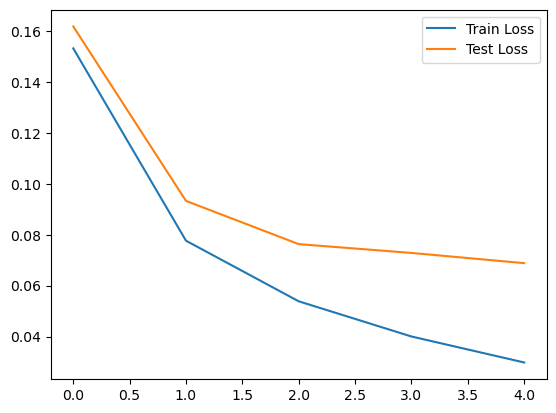

In [166]:
# add a plot of the train and test error graphs during training
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.legend()
plt.show()

In [167]:
# report the test error you obtain when training has finished
last = num_epochs - 1
last_lose_train = [train_loss_history[last]]
last_lose_test = [test_loss_history[last]]
print(last_lose_train)
print(last_lose_test)

[0.02980586519620071]
[0.06884790624288144]


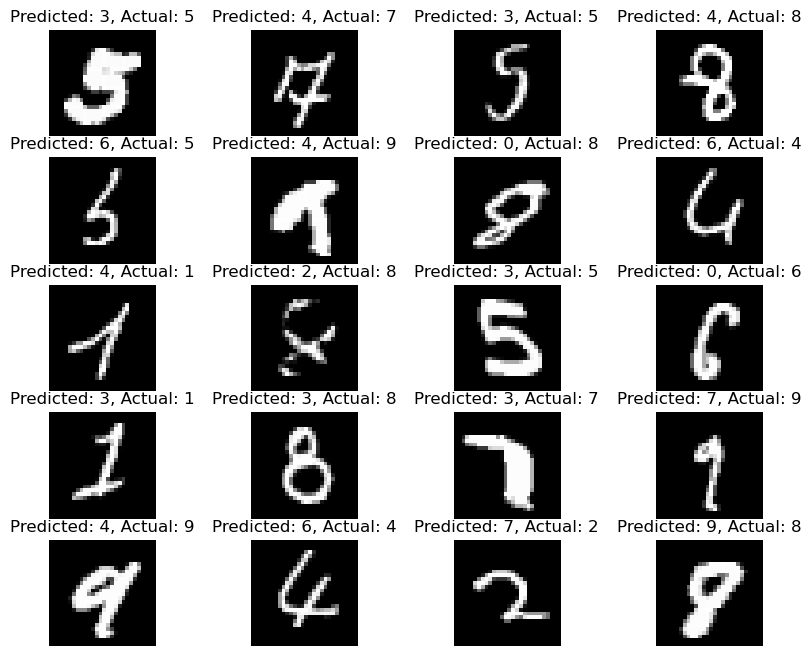

In [168]:
# attach to your report a plot of some of the misclassified images
misclassified = misclassified_images
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 8))
for ax, (img, pred, actual) in zip(axes.flat, misclassified[:20]):
    img = img.cpu().numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Predicted: {pred}, Actual: {actual}')
    ax.axis('off')
plt.show()